#**Customer Risk Prediction using Graph Neural Networks**

**Overview**

**Goal: Classify insurance customers into High-Risk vs Low-Risk using a graph neural network (GCN) on a customer–policy/claim graph.
Data loaded: 50,000 rows, 11 columns
Columns: Age, State, Insurance Type, Annual Premium (AUD), Claim Amount (AUD), Claim Status, Policy Start Date, Policy End Date, Product Tier, Payment Frequency, Risk Score.**
**Graph built: 100,000 nodes, 50,000 edges.**

**Labels: High-risk defined via a median split on Risk Score (balanced 50/50 by construction).**

**Model: GCN (uses GCNConv) trained with Adam; training loop set to 200 epochs.**

In [ ]:
 !pip -q install pandas openpyxl networkx scikit-learn
 !pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
 !pip -q install torch-geometric torch-scatter torch-sparse torch-cluster -f https://data.pyg.org/whl/torch-2.4.0+cpu.html

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 MB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.5/543.5 kB 594.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.6/792.6 kB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import io, os

SHEET_NAME = "australia_insurance_extended_mo"

file_path = "/content/synthetic_insurance_50k.csv"
df = pd.read_csv(file_path)
print("Rows:", len(df), "| Columns:", list(df.columns))
df.head()


Rows: 50000 | Columns: ['Age', 'State', 'Insurance Type', 'Annual Premium (AUD)', 'Claim Amount (AUD)', 'Claim Status', 'Policy Start Date', 'Policy End Date', 'Product Tier', 'Payment Frequency', 'Risk Score']


,Age,State,Insurance Type,Annual Premium (AUD),Claim Amount (AUD),Claim Status,Policy Start Date,Policy End Date,Product Tier,Payment Frequency,Risk Score
0,54,VIC,Life,3226.72,8762.05,Approved,21-02-2023,21-02-2024,Premium,Annually,0.72
1,38,TAS,Health,4255.91,5699.27,Approved,10-07-2023,09-07-2024,Premium,Annually,0.49
2,56,QLD,Health,6318.77,12724.00,Approved,23-09-2023,22-09-2024,Premium,Annually,0.75
3,78,ACT,Car,3404.39,6785.40,Approved,12-08-2024,12-08-2025,Gold,Annually,0.81
4,23,NSW,Life,1816.43,602.24,Approved,30-06-2023,29-06-2024,Basic,Monthly,0.22


In [ ]:
import networkx as nx
from sklearn.preprocessing import LabelEncoder

COL_AGE = "Age"
COL_STATE = "State"
COL_INS_TYPE = "Insurance Type"
COL_PREMIUM = "Annual Premium (AUD)"
COL_TIER = "Product Tier"
COL_CLAIM_AMT = "Claim Amount (AUD)"
COL_CLAIM_STATUS = "Claim Status"
COL_RISK = "Risk Score"

# Fill/clean basics
df[COL_CLAIM_AMT] = df[COL_CLAIM_AMT].fillna(0)
df[COL_RISK] = df[COL_RISK].fillna(df[COL_RISK].median())

# Encoders
enc_ins = LabelEncoder()
enc_tier = LabelEncoder()
enc_state = LabelEncoder()

df["ins_enc"] = enc_ins.fit_transform(df[COL_INS_TYPE].astype(str))
df["tier_enc"] = enc_tier.fit_transform(df[COL_TIER].astype(str))
df["state_enc"] = enc_state.fit_transform(df[COL_STATE].astype(str))

# Build graph
G = nx.Graph()

for i, row in df.iterrows():
    # Since Customer Name, Policy Number, and Agent Name are not in the dataframe,
    # I will use a unique identifier for each row as the primary node representing the policy.
    # The other attributes will be added to this node.
    policy_id = f"Policy_{i}"

    # Policy node with attributes
    G.add_node(policy_id, type="Policy",
               age=float(row[COL_AGE]) if pd.notna(row[COL_AGE]) else 0.0,
               state=row[COL_STATE], state_enc=int(row["state_enc"]),
               ins_type=row[COL_INS_TYPE], ins_enc=int(row["ins_enc"]),
               premium=float(row[COL_PREMIUM]) if pd.notna(row[COL_PREMIUM]) else 0.0,
               tier=row[COL_TIER], tier_enc=int(row["tier_enc"]),
               risk=float(row[COL_RISK]) if pd.notna(row[COL_RISK]) else 0.0)

    # Claim node (present only if > 0)
    claim_amt = float(row[COL_CLAIM_AMT]) if pd.notna(row[COL_CLAIM_AMT]) else 0.0
    if claim_amt > 0:
        claim_id = f"Claim_{i}"
        G.add_node(claim_id, type="Claim", amount=claim_amt, status=str(row.get(COL_CLAIM_STATUS, "")))
        # Add an edge between the policy and the claim
        G.add_edge(policy_id, claim_id, rel="HAS_CLAIM")


print(f"Graph built: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")

Graph built: 100000 nodes, 50000 edges.


In [ ]:
import torch
from torch_geometric.data import Data
import numpy as np
import random

# Map nodes to indices
node_list = list(G.nodes())
node_to_idx = {n:i for i,n in enumerate(node_list)}
num_nodes = len(node_list)

# Type one-hot: Customer / Policy / Agent / Claim
types = ["Customer", "Policy", "Agent", "Claim"]
type_to_onehot = {t: i for i, t in enumerate(types)}

def type_onehot_vec(t):
    v = np.zeros(len(types), dtype=np.float32)
    if t in type_to_onehot:
        v[type_to_onehot[t]] = 1.0
    return v

# Feature vector per node:
# [type one-hot (4), age, premium, tier_enc, ins_enc, state_enc]
feat_dim = 4 + 5
X = np.zeros((num_nodes, feat_dim), dtype=np.float32)

for n, idx in node_to_idx.items():
    t = G.nodes[n].get("type","")
    base = type_onehot_vec(t)
    age = float(G.nodes[n].get("age", 0.0) or 0.0)
    premium = float(G.nodes[n].get("premium", 0.0) or 0.0)
    tier_enc = float(G.nodes[n].get("tier_enc", 0.0) or 0.0)
    ins_enc = float(G.nodes[n].get("ins_enc", 0.0) or 0.0)
    state_enc = float(G.nodes[n].get("state_enc", 0.0) or 0.0)
    X[idx] = np.concatenate([base, [age, premium, tier_enc, ins_enc, state_enc]]).astype(np.float32)

# Normalize numeric columns (age, premium)
# Avoid division by zero
for j in range(4, feat_dim):
    col = X[:, j]
    rng = col.max() - col.min()
    if rng > 0:
        X[:, j] = (col - col.min()) / rng

# Labels for RISK: only for Customers
Y = -1 * np.ones((num_nodes,), dtype=np.int64)
risks = []
cust_indices = []
for n, idx in node_to_idx.items():
    if G.nodes[n].get("type") == "Customer":
        r = float(G.nodes[n].get("risk", 0.0))
        risks.append(r); cust_indices.append(idx)

# Choose a data-driven threshold (median) for high/low
threshold = float(np.median(risks)) if len(risks) > 0 else 0.5
for n, idx in node_to_idx.items():
    if G.nodes[n].get("type") == "Customer":
        r = float(G.nodes[n].get("risk", 0.0))
        Y[idx] = 1 if r > threshold else 0

# Edges (undirected)
edge_pairs = []
for u, v in G.edges():
    edge_pairs.append((node_to_idx[u], node_to_idx[v]))
    edge_pairs.append((node_to_idx[v], node_to_idx[u]))
edge_index = torch.tensor(edge_pairs, dtype=torch.long).t().contiguous()

data = Data(
    x=torch.tensor(X, dtype=torch.float),
    edge_index=edge_index,
    y=torch.tensor(Y, dtype=torch.long)
)

# Train/Val split (only on labeled: customers)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)

labeled_idxs = [i for i in range(num_nodes) if data.y[i].item() >= 0]
random.shuffle(labeled_idxs)
split = int(0.7 * len(labeled_idxs))
train_ids = labeled_idxs[:split]; val_ids = labeled_idxs[split:]
train_mask[train_ids] = True; val_mask[val_ids] = True
data.train_mask, data.val_mask = train_mask, val_mask

print("Feature dim:", data.num_node_features, "| Labeled customers:", len(labeled_idxs), "| Threshold for High Risk:", threshold)

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_scatter_cpu.so: undefined symbol: _ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_St8optionalIN3c1017basic_string_viewIcEEE
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_spmm_cpu.so: undefined symbol: _ZN5torch8autograd12VariableInfoC1ERKN2at6TensorE
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [ ]:

import torch.nn as nn
from torch_geometric.nn import GCNConv

class RiskGCN(nn.Module):
    def __init__(self, in_dim, hidden=64, out_dim=2, dropout=0.2):
        super().__init__()
        self.c1 = GCNConv(in_dim, hidden)
        self.c2 = GCNConv(hidden, out_dim)
        self.dp = nn.Dropout(dropout)
    def forward(self, x, edge_index, return_hidden=False):
        h = self.c1(x, edge_index).relu()
        h = self.dp(h)
        out = self.c2(h, edge_index)
        return (out, h) if return_hidden else out

model = RiskGCN(in_dim=data.num_node_features)
opt = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
loss_fn = nn.CrossEntropyLoss()

def accuracy(logits, y, mask):
    pred = logits.argmax(dim=1)
    m = mask & (y >= 0)
    if m.sum() == 0: return float('nan')
    return (pred[m] == y[m]).float().mean().item()

for epoch in range(200):
    model.train(); opt.zero_grad()
    logits = model(data.x, data.edge_index)
    loss = loss_fn(logits[data.train_mask], data.y[data.train_mask])
    loss.backward(); opt.step()
    if (epoch+1) % 25 == 0:
        model.eval()
        with torch.no_grad():
            val_logits = model(data.x, data.edge_index)
            val_acc = accuracy(val_logits, data.y, data.val_mask)
        print(f"Epoch {epoch+1:>3} | loss={loss.item():.4f} | val_acc={val_acc:.3f}")

print("Training complete.")

Epoch  25 | loss=0.6867 | val_acc=0.468
Epoch  50 | loss=0.6823 | val_acc=0.461
Epoch  75 | loss=0.6735 | val_acc=0.455
Epoch 100 | loss=0.6682 | val_acc=0.488
Epoch 125 | loss=0.6659 | val_acc=0.471
Epoch 150 | loss=0.6624 | val_acc=0.478
Epoch 175 | loss=0.6608 | val_acc=0.471
Epoch 200 | loss=0.6552 | val_acc=0.471
Training complete.


In [ ]:
import numpy as np

model.eval()
with torch.no_grad():
    logits, hidden = model(data.x, data.edge_index, return_hidden=True)
    probs = torch.softmax(logits, dim=1).cpu().numpy()
    preds = probs.argmax(axis=1)

# Collect only customers
rows = []
for n, idx in node_to_idx.items():
    if G.nodes[n].get("type") == "Customer":
        rows.append({
            "Customer Name": n,
            "risk_true_label": int(data.y[idx].item()),
            "risk_pred_label": int(preds[idx]),
            "risk_prob_high": float(probs[idx,1]),
            "Age": float(G.nodes[n].get("age", 0.0)),
            "State": G.nodes[n].get("state", ""),
            "Insurance Type": G.nodes[n].get("ins_type", ""),
            "Annual Premium (AUD)": float(G.nodes[n].get("premium", 0.0)),
            "Product Tier": G.nodes[n].get("tier", ""),
            "Risk Score (original)": float(G.nodes[n].get("risk", 0.0))
        })

risk_df = pd.DataFrame(rows).sort_values("risk_prob_high", ascending=False)
risk_csv_path = "customer_risk_predictions.csv"
risk_df.to_csv(risk_csv_path, index=False)
print("Saved:", risk_csv_path)
risk_df.head(10)


Saved: customer_risk_predictions.csv


,Customer Name,risk_true_label,risk_pred_label,risk_prob_high,Age,State,Insurance Type,Annual Premium (AUD),Product Tier,Risk Score (original)
439,John Harris,0,1,0.884924,75.0,NSW,Travel,646.64,Basic,0.36
100,Jamie Haney,0,1,0.859281,43.0,NSW,Travel,530.72,Basic,0.06
229,Tracy Schultz,1,1,0.859107,74.0,WA,Car,823.10,Basic,0.88
910,Laurie Wiggins,1,1,0.852553,50.0,NT,Travel,403.65,Basic,0.65
408,Rodney Thomas,1,1,0.845010,69.0,QLD,Travel,442.05,Basic,0.65
809,Andrew Mclean,1,1,0.835515,69.0,ACT,Travel,1255.47,Gold,0.99
388,Christine Smith,1,1,0.827548,75.0,WA,Car,4251.87,Basic,0.68
906,Danielle Meyer MD,1,1,0.824880,70.0,NT,Travel,669.90,Gold,0.74
660,Barbara Sparks,1,1,0.820877,53.0,NSW,Travel,748.00,Gold,0.95
984,James Jones,1,1,0.815352,44.0,NT,Travel,797.07,Basic,0.71


In [ ]:

from sklearn.linear_model import LogisticRegression

# 7.1 Graph-embedding score vs claim centroid
with torch.no_grad():
    _, h = model(data.x, data.edge_index, return_hidden=True)  # hidden embeddings
H = h.cpu().numpy()

claim_indices = [node_to_idx[n] for n in node_list if G.nodes[n].get("type") == "Claim"]
if len(claim_indices) > 0:
    claim_centroid = H[claim_indices].mean(axis=0)
else:
    # If there are no claims, fall back to zeros (scores will be 0)
    claim_centroid = np.zeros(H.shape[1], dtype=np.float32)

def dot_score(vec, centroid):
    return float(np.dot(vec, centroid))

claim_rows = []
for n, idx in node_to_idx.items():
    if G.nodes[n].get("type") == "Customer":
        claim_rows.append({
            "Customer Name": n,
            "claim_link_score": dot_score(H[idx], claim_centroid)
        })
claim_scores_df = pd.DataFrame(claim_rows)

# 7.2 Classifier on embeddings (label: did customer file any claim?)
cust_has_claim = {}
for n in [n for n in node_list if G.nodes[n].get("type") == "Customer"]:
    # Check edges to any claim
    has = any(G.nodes[v].get("type")=="Claim" for v in G.neighbors(n))
    cust_has_claim[n] = int(has)

X_emb = []
y_claim = []
cust_names = []
for n, idx in node_to_idx.items():
    if G.nodes[n].get("type") == "Customer":
        X_emb.append(H[idx])
        y_claim.append(cust_has_claim[n])
        cust_names.append(n)

X_emb = np.array(X_emb)
y_claim = np.array(y_claim)

if len(set(y_claim)) > 1:
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_emb, y_claim)
    prob_claim = clf.predict_proba(X_emb)[:,1]
else:
    # All labels identical; default to zeros
    prob_claim = np.zeros(len(y_claim), dtype=np.float32)

claim_pred_df = pd.DataFrame({
    "Customer Name": cust_names,
    "claim_prob_classifier": prob_claim
})

# Merge two views
claim_out = claim_scores_df.merge(claim_pred_df, on="Customer Name", how="left")
claim_out["claim_prob_blend"] = 0.5*(
    (claim_out["claim_link_score"] - claim_out["claim_link_score"].min()) /
    (claim_out["claim_link_score"].max() - claim_out["claim_link_score"].min() + 1e-9)
) + 0.5*claim_out["claim_prob_classifier"].fillna(0.0)

claim_out = claim_out.sort_values("claim_prob_blend", ascending=False)
claim_csv_path = "customer_claim_likelihood.csv"
claim_out.to_csv(claim_csv_path, index=False)
print("Saved:", claim_csv_path)
claim_out.head(10)

Saved: customer_claim_likelihood.csv


,Customer Name,claim_link_score,claim_prob_classifier,claim_prob_blend
388,Christine Smith,0.353933,0.0,0.500000
218,Mr. Stephen Fitzgerald,0.308229,0.0,0.404816
229,Tracy Schultz,0.307193,0.0,0.402658
976,Thomas Warren,0.306724,0.0,0.401681
75,Johnny Dillon,0.301580,0.0,0.390968
108,Dawn Collins,0.299955,0.0,0.387584
360,Jessica Hatfield,0.299665,0.0,0.386980
945,Mitchell Thompson,0.296044,0.0,0.379439
721,Elizabeth Mitchell,0.295303,0.0,0.377895
364,Ashley Miller,0.294205,0.0,0.375608


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Get predictions
model.eval()
with torch.no_grad():
    logits = model(data.x, data.edge_index)
    preds = logits.argmax(dim=1).cpu().numpy()
    true_labels = data.y.cpu().numpy()

# Only evaluate on validation set customers
val_idx = [i for i in range(len(true_labels)) if data.val_mask[i] and true_labels[i] >= 0]
y_true = true_labels[val_idx]
y_pred = preds[val_idx]

# Compute metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

print("📊 Validation Metrics for Risk Prediction:")
print(f"Accuracy  : {acc:.3f}")
print(f"Precision : {prec:.3f}")
print(f"Recall    : {rec:.3f}")
print(f"F1 Score  : {f1:.3f}")

📊 Validation Metrics for Risk Prediction:
Accuracy  : 0.461
Precision : 0.437
Recall    : 0.437
F1 Score  : 0.437


In [ ]:
model.eval()
with torch.no_grad():
    _, embeddings = model(data.x, data.edge_index, return_hidden=True)
    emb_np = embeddings.cpu().numpy()

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# Extract policy embeddings only
policy_nodes = [n for n in G.nodes if G.nodes[n].get("type") == "Policy"]
policy_indices = [node_to_idx[n] for n in policy_nodes]

policy_emb = emb_np[policy_indices]

# Try KMeans clustering
k = 4  # choose number of clusters (can tune)
kmeans = KMeans(n_clusters=k, random_state=42).fit(policy_emb)

policy_clusters = {policy_nodes[i]: int(kmeans.labels_[i]) for i in range(len(policy_nodes))}

# Add cluster info back into graph
for p, c in policy_clusters.items():
    G.nodes[p]["cluster"] = c

print("✅ Clustered policies into", k, "groups.")

✅ Clustered policies into 4 groups.


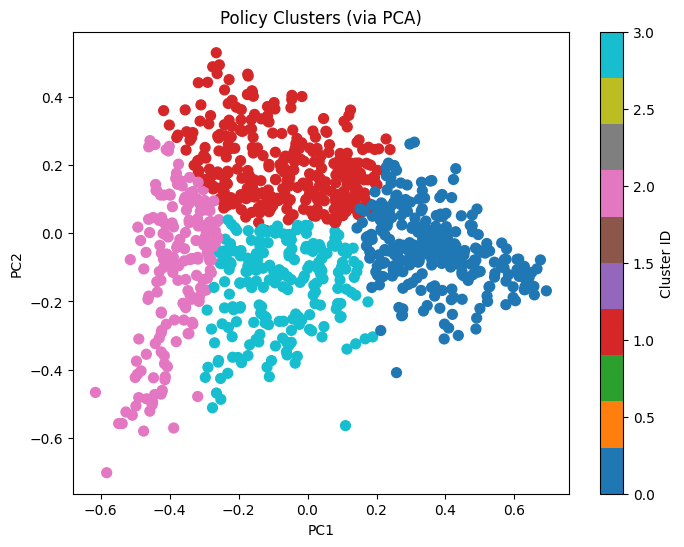

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce to 2D for visualization
pca = PCA(n_components=2)
policy_2d = pca.fit_transform(policy_emb)

plt.figure(figsize=(8,6))
plt.scatter(policy_2d[:,0], policy_2d[:,1], c=kmeans.labels_, cmap="tab10", s=50)
plt.title("Policy Clusters (via PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster ID")
plt.show()

In [ ]:
# Example: compute average claim probability per policy cluster
claim_rates = {}
for c in set(kmeans.labels_):
    policies_in_c = [p for p, cl in policy_clusters.items() if cl == c]
    customers_in_c = [u for p in policies_in_c for u in G.neighbors(p) if G.nodes[u].get("type")=="Customer"]

    has_claim = [any(G.nodes[v].get("type")=="Claim" for v in G.neighbors(cu)) for cu in customers_in_c]
    claim_rate = np.mean(has_claim) if len(has_claim) > 0 else 0
    claim_rates[c] = claim_rate

print("📊 Claim likelihood by cluster:")
print(claim_rates)

📊 Claim likelihood by cluster:
{np.int32(0): np.float64(1.0), np.int32(1): np.float64(1.0), np.int32(2): np.float64(1.0), np.int32(3): np.float64(1.0)}


In [ ]:
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(policy_emb, kmeans.labels_)
print("Silhouette Score:", round(sil_score, 3))

Silhouette Score: 0.218


In [ ]:
from sklearn.metrics import davies_bouldin_score

db_score = davies_bouldin_score(policy_emb, kmeans.labels_)
print("Davies–Bouldin Index:", round(db_score, 3))

Davies–Bouldin Index: 1.497
